In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
#create base
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
#display meaasurement table data 
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#display station table data 
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f'The most recent date found is: {recent_date}.')

The most recent date found is: ('2017-08-23',).


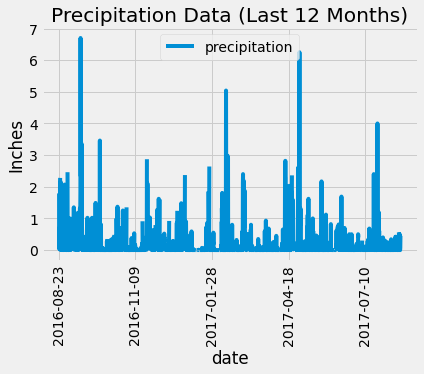

In [134]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
prev_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d').date() - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
pcp_data = session.query(measurement.date,measurement.prcp).\
            filter(measurement.date >= prev_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
pcp_df = pd.DataFrame(pcp_data, columns=['date', 'precipitation'])
#pcp_df = pcp_df.set_index('date')
pcp_df
# Sort the dataframe by date
pcp_df_by_date = pcp_df.sort_values(by='date')
# Use Pandas Plotting with Matplotlib to plot the data
fig = pcp_df_by_date.plot(x ='date')
plt.xticks(rotation="vertical")
fig.set_ylabel('Inches')
plt.title('Precipitation Data (Last 12 Months)')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = pcp_df.agg({'precipitation':['mean','median','var','std','sem']})
summary_stats

,precipitation
mean,0.177279
median,0.020000
var,0.212696
std,0.461190
sem,0.010259


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).distinct().count()
total_stations

9

In [68]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(measurement.station,func.count(measurement.station)).\
                group_by(measurement.station).\
                order_by(func.count(measurement.station).desc()).all()

most_active

'USC00519281'

In [84]:
# Using the most active station id from the previous query, calculate the lowest temp
lowest_temp = session.query(func.min(measurement.tobs)).\
            filter(measurement.station == most_active[0][0]).scalar()
print(f'The lowest temperataure recorded for station:{most_active[0][0]} is {lowest_temp}')

#Using the most active station id from the previous query, calculate the highest temp
highest_temp = session.query(func.max(measurement.tobs)).\
            filter(measurement.station == most_active[0][0]).scalar()
print(f'The highest temperataure recorded for station:{most_active[0][0]} is {highest_temp}')

#Using the most active station id from the previous query, calculate the average temperature.
average_temp = session.query(func.round(func.avg(measurement.tobs)),2).\
            filter(measurement.station == most_active[0][0]).scalar()
print(f'The average temperataure recorded for station:{most_active[0][0]} is {average_temp}')

The lowest temperataure recorded for station:USC00519281 is 54.0
The highest temperataure recorded for station:USC00519281 is 85.0
The average temperataure recorded for station:USC00519281 is 72.0


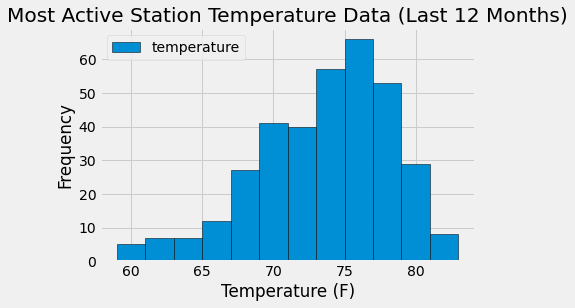

In [133]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
prev_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d').date() - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
station_data = session.query(measurement.tobs,measurement.station).\
            filter(measurement.station == most_active[0][0]).\
            filter(measurement.date >= prev_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
station_df = pd.DataFrame(station_data, columns=['temperature','frequency'])
station_df

# Use Pandas Plotting with Matplotlib to plot the data
fig2 = station_df.plot.hist(station_df['temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature (F)')
plt.title('Most Active Station Temperature Data (Last 12 Months)')
plt.show()

# Close session

In [135]:
# Close Session
session.close()